<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/barcode_validator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [25]:
bcs = [
  "GGAGAAGA",
  "CCACAATG",
  "CCAACCGG",
  "CGAAGCCC",
  "TCAGTCGA",
  "GACCAGCC",
  "CTCAAGGT",
  "CGCCGCAA",
  "ACCAGCCG",
]

bcs_names = [
"BC1",
"BC2",
"BC13",
"BC25",
"BC37",
"BC49",
"BC50",
"BC73",
"BC74",
]

# Validation

## Length validation

In [26]:
bc_len = min([len(i) for i in bcs])

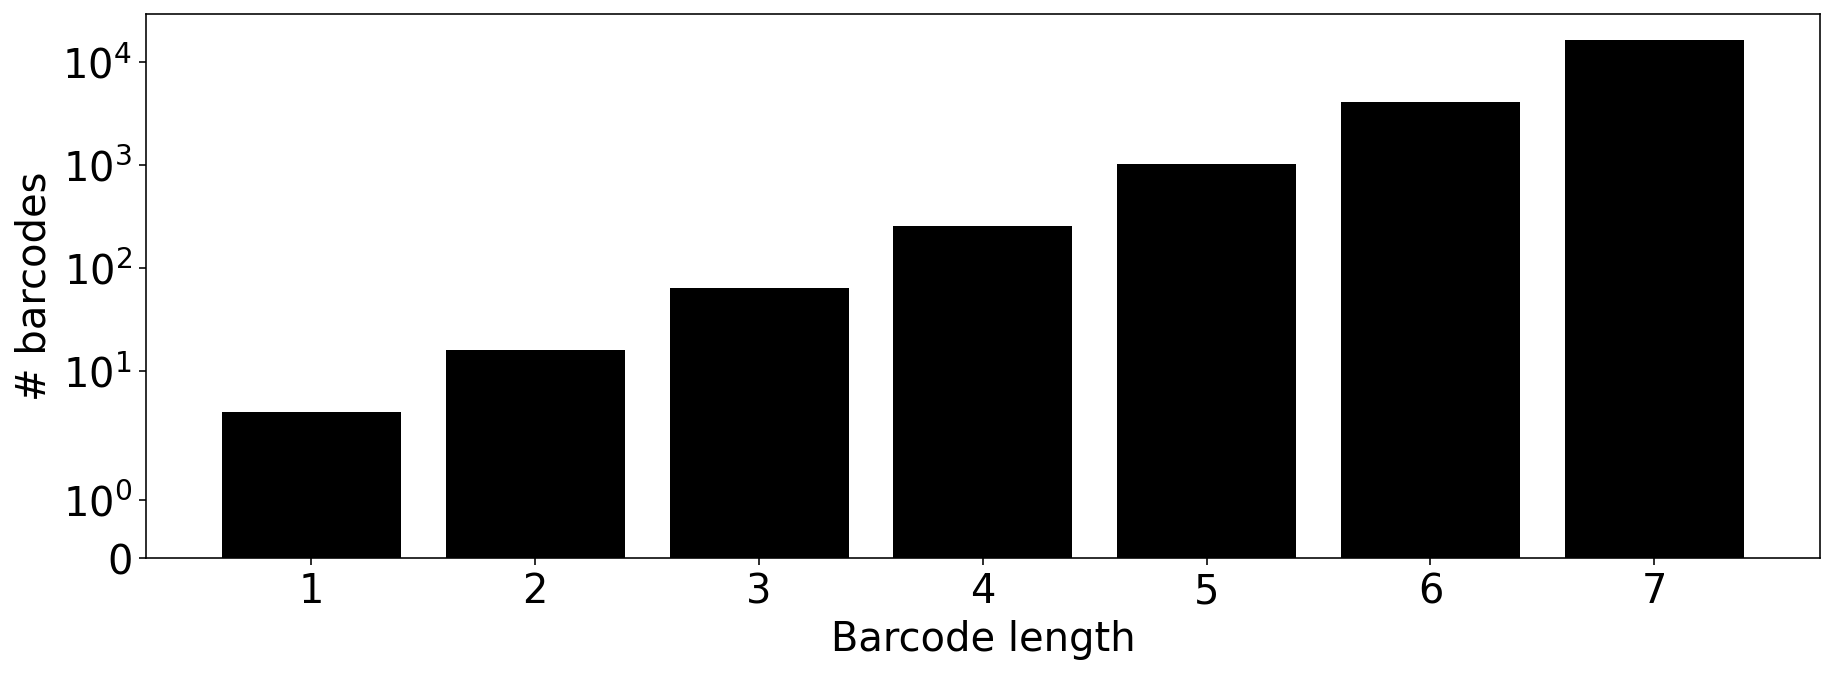

In [27]:
fig, ax = plt.subplots(figsize=(15,5))

x = np.arange (1, bc_len)
y = 4**x

ax.bar(x, y, color="k")
ax.set(**{
    "yscale": "symlog",
    "xticks": x,
    "xlabel": "Barcode length",
    "ylabel": "# barcodes"
})
fig.savefig("barcode_diversity.png", dpi=300, bbox_inches="tight")
fig.show()


## Shared subsequence

In [28]:
def kmerize(s, k):
  L = len(s)
  return [s[i:i+k] for i in range(L-k+1)]
kmerize("sina" ,3)

['sin', 'ina']

In [29]:
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
def rev_c(seq):
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases
rev_c("ATC")

'GAT'

In [30]:
from collections import defaultdict
def check_kmers(bcs, bcs_names, k=None):
  length = min([len(i) for i in bcs])
  if not k:
    k = length if length % 2 else length - 1
    print(f"Optimal kmer length: {k}")

  d = defaultdict(list)
  for bc, bc_name in zip(bcs, bcs_names):
    # forward strand
    kmers = kmerize(bc, k)
    for kmer in kmers:
      d["".join(kmer)].append(bc_name)
    
    # reverse complement strand
    kmers = kmerize(rev_c(bc), k)
    for kmer in kmers:
      d["".join(kmer)].append(bc_name + "_rc")
  return d

In [31]:
for k, v in check_kmers(bcs, bcs_names).items():
  if len(v) > 1:
    print(k, v)

Optimal kmer length: 7
ACCAGCC ['BC49', 'BC74']
GGCTGGT ['BC49_rc', 'BC74_rc']


### Varying length of subesequnce

In [32]:
# across multiple kmer lengths
kmer_lens = np.arange(2, bc_len + 1)
ambig_bcs = []
for kmer_len in kmer_lens:
  # Determine the set of ambiguous barcodes
  ambig_bc = set()
  for i in check_kmers(bcs, bcs_names, kmer_len).values():
    if len(i) > 1:
      for j in i:
        ambig_bc.add(j.split("_")[0])
  ambig_bcs.append(len(ambig_bc))


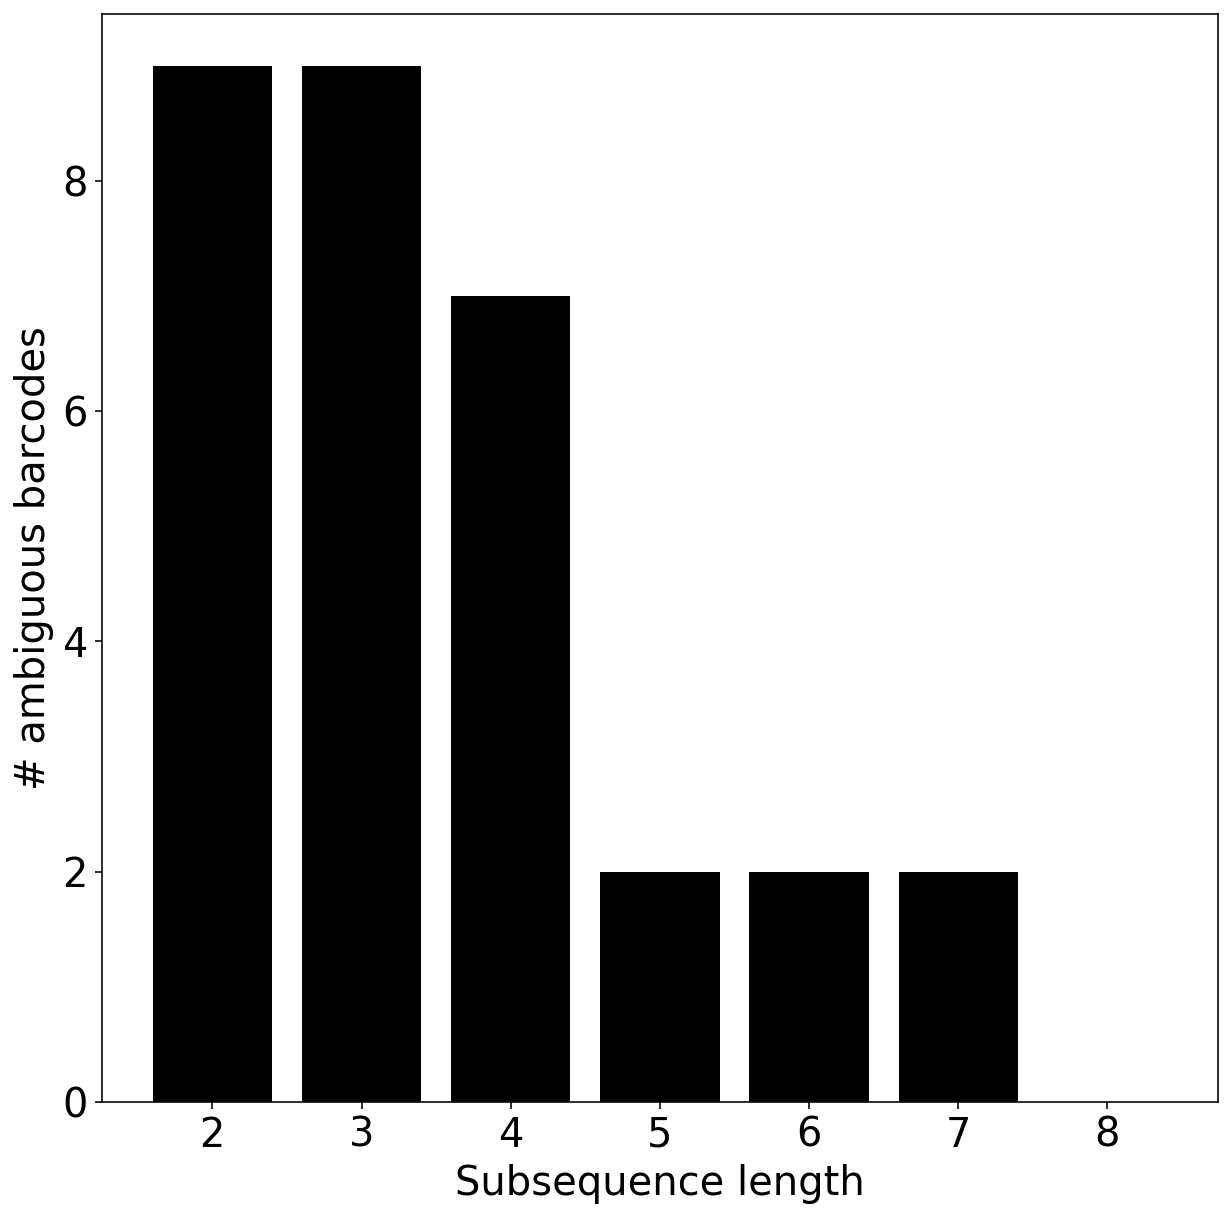

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

x = kmer_lens
y = ambig_bcs

ax.bar(x, y, color="k")
ax.set(**{
    "xticks": x,
    "xlabel": "Subsequence length",
    "ylabel": "# ambiguous barcodes"
})
fig.savefig("shared_subseq.png", dpi=300, bbox_inches="tight")

fig.show()

## Pairwise hamming / edit distance

In [34]:
n_bcs = len(bcs)
mat = np.zeros(( n_bcs, n_bcs ))
for i in range(len(bcs)):
  for j in range(i, len(bcs)):
    first  = np.array(list(bcs[i]))
    second = np.array(list(bcs[j]))
    mat[i,j] = (first!=second).sum()

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

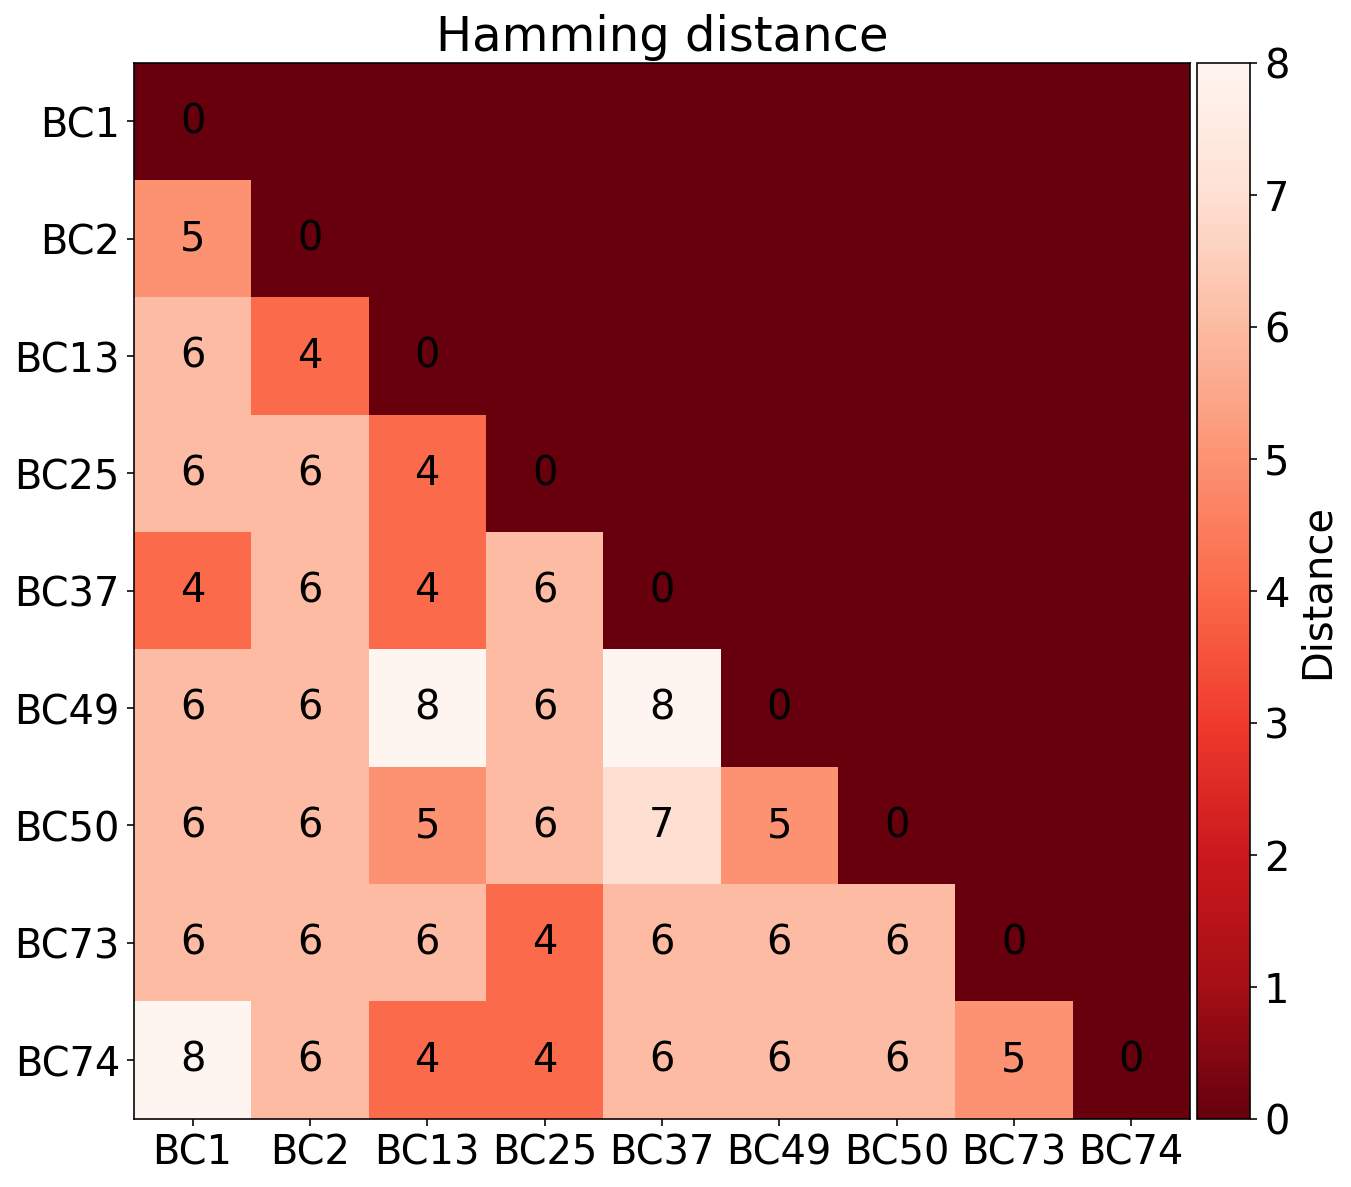

In [36]:
fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(mat.T, cmap="Reds_r")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, label="Distance", cax=cax)

for (j,i),label in np.ndenumerate(mat.T):
  ham = mat[i,j]
  if i <= j:
    string = f"{ham:,.0f}"
    ax.text(i,j,string,ha='center',va='center')

ax.set(**{
    "xticklabels": bcs_names,
    "yticklabels": bcs_names,
    "xticks": np.arange(len(bcs_names)),
    "yticks": np.arange(len(bcs_names)),
    "title": "Hamming distance"
})

fig.savefig("pairwise.png", dpi=300, bbox_inches="tight")

fig.show()